In [3]:
import nibabel as nib
from glob import glob
import os
import numpy as np
import matplotlib.pyplot as plt

import torch

In [2]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [4]:
TRAIN_DATASET_PATH = '../BraTS2021_Training_Data/'

## pre-processing (creating 2d slices dataset)

In [ ]:
t2_list = sorted(glob('../BraTS2021_Training_Data/*/*t2.nii.gz'))
# glob returns a list of paths matching the given pattern != from os.listdir that does not return entire paths

t1ce_list = sorted(glob('../BraTS2021_Training_Data/*/*t1ce.nii.gz'))

flair_list = sorted(glob('../BraTS2021_Training_Data/*/*flair.nii.gz'))

mask_list = sorted(glob('../BraTS2021_Training_Data/*/*seg.nii.gz'))

for each volume in dataset:
- we load the corresponding modalities and combine them 
- we load the mask and adjust it (ex. make labels integers)
- resize both volume and mask
exactly like for the 3D dataset!!

BUT NOW we also:
extract the slices of the volume one by one and save them as numpy arrays together with the corresponding mask slice after converting them in categorical format

In [ ]:
for img in range(len(t2_list)):   #Using t2_list as all lists are of same size
    print("Now preparing image and masks number: ", img)
      
    temp_image_t2=nib.load(t2_list[img]).get_fdata()
    temp_image_t2=scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)
   
    temp_image_t1ce=nib.load(t1ce_list[img]).get_fdata()
    temp_image_t1ce=scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)
   
    temp_image_flair=nib.load(flair_list[img]).get_fdata()
    temp_image_flair=scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)
        
    temp_mask=nib.load(mask_list[img]).get_fdata()
    temp_mask=temp_mask.astype(np.uint8)
    temp_mask[temp_mask==4] = 3  
    
    temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2], axis=3)

    #temp_combined_images=temp_combined_images[24:216, 24:216, 13:141] ---> 192, 192, 128
    #temp_mask = temp_mask[24:216, 24:216, 13:141]
    #                  OR
    temp_combined_images=temp_combined_images[56:184, 56:184, 13:141]
    temp_mask = temp_mask[56:184, 56:184, 13:141]
    
    for slice in range(temp_mask.shape[2]):
        val, counts = np.unique(temp_mask[:,:,slice], return_counts=True)
        if (1 - (counts[0]/counts.sum())) > 0.02:  #At least 2% useful slices with labels that are not 0 = background (principalmente per avere un dataset più piccolo rispetto a come sarebbe se prendessi tutte le slices possibili)
            print("Save Me")

            slice_mask = temp_mask[:,:,slice]
            temp_mask_one_hot = torch.zeros((*slice_mask.shape, 4), dtype=torch.float32)
            temp_mask_one_hot.scatter_(2, torch.unsqueeze(torch.tensor(slice_mask, dtype=torch.int64), 2), 1)
            
            output_dir = 'BraTS2021_TrainingData_2d/input_data_3channels'
            image_dir = os.path.join(output_dir, 'images')
            mask_dir = os.path.join(output_dir, 'masks')
            os.makedirs(image_dir, exist_ok=True)
            os.makedirs(mask_dir, exist_ok=True)
            np.save('BraTS2021_TrainingData_2d/input_data_3channels/images/image_'+str(img)+'_'+str(slice)+'.npy', temp_combined_images[:,:,slice,:])
            np.save('BraTS2021_TrainingData_2d/input_data_3channels/masks/mask_'+str(img)+'_'+str(slice)+'.npy', temp_mask_one_hot)
            
        else:
            print("I am useless") 
   

# Split data into train and validation

import splitfolders 

input_folder = 'BraTS2021_TrainingData_2d/input_data_3channels/'
output_folder = 'BraTS2021_TrainingData_2d/input_data_128/'

# Split with ratio 80/20
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.8, .2), group_prefix=None) # default values

## example of previous procedure on one volume

In [5]:
temp_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS2021_00495/BraTS2021_00495_t2.nii.gz').get_fdata()
temp_image_t2=scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)

temp_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS2021_00495/BraTS2021_00495_t1ce.nii.gz').get_fdata()
temp_image_t1ce=scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)

temp_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS2021_00495/BraTS2021_00495_flair.nii.gz').get_fdata()
temp_image_flair=scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)
    
temp_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS2021_00495/BraTS2021_00495_seg.nii.gz').get_fdata()
temp_mask=temp_mask.astype(np.uint8)
temp_mask[temp_mask==4] = 3  #Reassign mask values 4 to 3

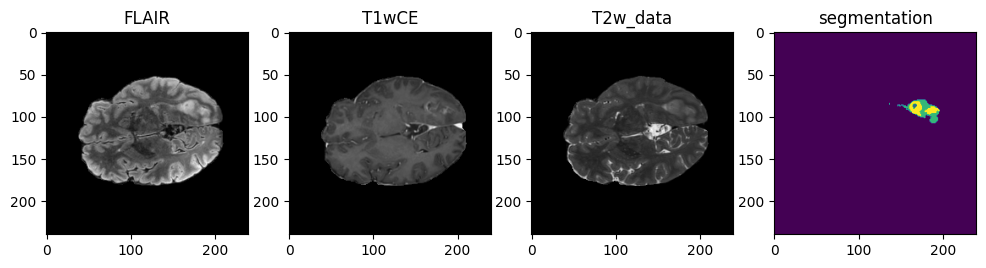

In [6]:
plt.figure(figsize=(12,6))

slice = 70

plt.subplot(141)
plt.title('FLAIR')
plt.imshow(temp_image_flair[:,:,slice], cmap='gray') # we are selecting slice 70 (in total there are 155 per volume)
plt.subplot(142)
plt.title('T1wCE')
plt.imshow(temp_image_t1ce[:,:,slice], cmap='gray')
plt.subplot(143)
plt.title('T2w_data')
plt.imshow(temp_image_t2[:,:,slice], cmap='gray')
plt.subplot(144)
plt.title('segmentation')
plt.imshow(temp_mask[:,:,slice])

In [7]:
temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2], axis=3)
temp_combined_images.shape

(240, 240, 155, 3)

In [8]:
#temp_combined_images = temp_combined_images[24:216, 24:216, 13:141] # crop to 192 x 192 x 128 x 3
#temp_mask = temp_mask[24:216, 24:216, 13:141]

temp_combined_images=temp_combined_images[56:184, 56:184, 13:141] # crop to 128 x 128 x 128 x 3
temp_mask = temp_mask[56:184, 56:184, 13:141]
temp_mask.shape

(128, 128, 128)

In [ ]:
for slice in range(temp_mask.shape[2]):
    val, counts = np.unique(temp_mask[:,:,slice], return_counts=True)
    if (1 - (counts[0]/counts.sum())) > 0.02:
        # At least 2% useful slices with labels that are not 0 = background
        # (principalmente per avere un dataset più piccolo rispetto a come sarebbe se prendessi tutte le slices possibili e per avere un dataset con minore class imbalance)
        print("Save")

        slice_mask = temp_mask[:,:,slice]
        temp_mask_one_hot = torch.zeros((*slice_mask.shape, 4), dtype=torch.float32)
        temp_mask_one_hot.scatter_(2, torch.unsqueeze(torch.tensor(slice_mask, dtype=torch.int64), 2), 1)
        
        output_dir = 'BraTS2021_TrainingData_2d/input_data_3channels'
        image_dir = os.path.join(output_dir, 'images')
        mask_dir = os.path.join(output_dir, 'masks')
        os.makedirs(image_dir, exist_ok=True)
        os.makedirs(mask_dir, exist_ok=True)
        np.save('BraTS2021_TrainingData_2d/input_data_3channels/images/image_2'+'_'+str(slice)+'.npy', temp_combined_images[:,:,slice,:])
        np.save('BraTS2021_TrainingData_2d/input_data_3channels/masks/mask_2'+'_'+str(slice)+'.npy', temp_mask_one_hot)
        
    else:
        print("Useless slice") # mainly background --> increases class imbalance

In [11]:
print(temp_mask_one_hot.shape)

torch.Size([128, 128, 4])


In [27]:
my_img=np.load('BraTS2021_TrainingData_2d/input_data_128/train/images/image_1_71.npy')
my_mask=np.load('BraTS2021_TrainingData_2d/input_data_128/train/masks/mask_1_71.npy')

#print(my_img.shape) # --> (128, 128, 3)
#print(my_mask.shape) # --> (128, 128, 4)

In [28]:
test_mask=np.argmax(my_mask, axis=2)

#print(test_mask.shape) # --> (128, 128)

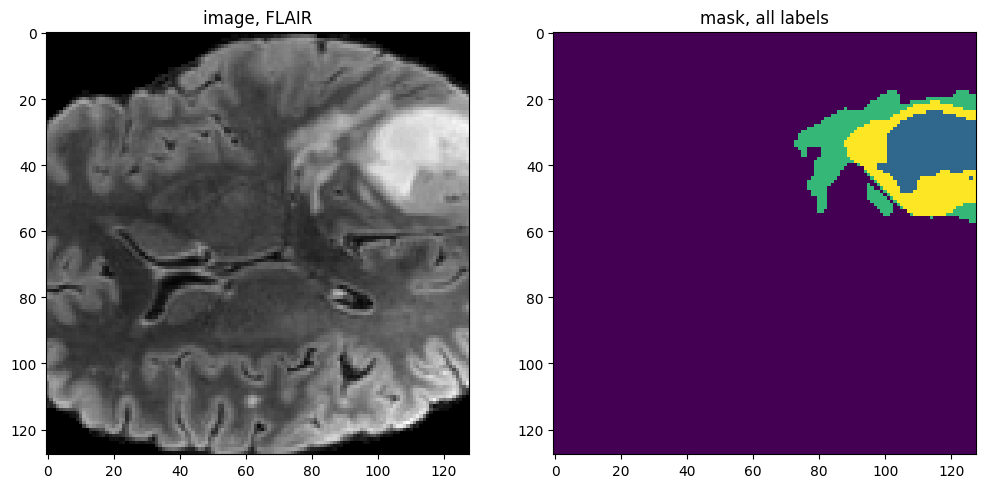

In [29]:
plt.figure(figsize=(12,6))

plt.subplot(121)
plt.title('image, FLAIR')
plt.imshow(my_img[:,:,0], cmap= 'gray')
plt.subplot(122)
plt.title('mask, all labels')
plt.imshow(test_mask[:,:]) 